In [1]:
import pyspark as ps
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[8]')
         .appName('casestudy')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
test_schema=StructType( [
   StructField('user',IntegerType(),True),
   StructField('movie',IntegerType(),True),
   StructField('rating',IntegerType(),True)] )

In [4]:
rdd = spark.read.load('data/requests.csv', format='csv', header=True, schema=test_schema)

In [5]:
rdd.show(5)

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|4958| 1924|  null|
|4958| 3264|  null|
|4958| 2634|  null|
|4958| 1407|  null|
|4958| 2399|  null|
+----+-----+------+
only showing top 5 rows



In [6]:
schema=StructType( [
   StructField('user',IntegerType(),True),
   StructField('movie',IntegerType(),True),
   StructField('rating',IntegerType(),True),
   StructField('tmstmp',IntegerType(),True),] )

In [7]:
train_rdd = spark.read.load('data/training.csv', format='csv', header=True, schema=schema)

In [8]:
train_rdd.show(5)

+----+-----+------+---------+
|user|movie|rating|   tmstmp|
+----+-----+------+---------+
|6040|  858|     4|956703932|
|6040|  593|     5|956703954|
|6040| 2384|     4|956703954|
|6040| 1961|     4|956703977|
|6040| 2019|     5|956703977|
+----+-----+------+---------+
only showing top 5 rows



In [9]:
train_rdd = train_rdd.select('user', 'movie', 'rating')

In [10]:
train_rdd.printSchema()

root
 |-- user: integer (nullable = true)
 |-- movie: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [11]:
mu = train_rdd.select('rating').groupby().mean().collect()[0][0]

In [12]:
mean_rating = rdd.withColumn('rating', F.lit(mu))

In [13]:
mean_rating.show(5)

+----+-----+----------+
|user|movie|    rating|
+----+-----+----------+
|4958| 1924|3.59047875|
|4958| 3264|3.59047875|
|4958| 2634|3.59047875|
|4958| 1407|3.59047875|
|4958| 2399|3.59047875|
+----+-----+----------+
only showing top 5 rows



In [15]:
train, test = train_rdd.randomSplit([0.8,0.2],seed=0)

In [16]:
als_model = ALS(
                itemCol = 'movie',
                userCol = 'user',
                ratingCol = 'rating',
                nonnegative = True,
                regParam = 0.1,
                rank = 10)


In [17]:
recommender = als_model.fit(train_rdd)

In [18]:
train_preds = recommender.transform(train_rdd)

In [19]:
test_preds = recommender.transform(rdd)

In [20]:
train_preds.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
| 673|  148|     5| 3.7936022|
|4227|  148|     2| 1.9551136|
|3184|  148|     4| 3.3017168|
|4784|  148|     3| 2.8758423|
|2383|  148|     2| 2.2598424|
|1242|  148|     3|  2.824234|
|3539|  148|     3| 2.7388778|
|1069|  148|     2| 2.4736655|
|1605|  148|     2| 2.2630243|
|1150|  148|     2| 2.4687316|
+----+-----+------+----------+
only showing top 10 rows



In [21]:
test_preds.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
|  53|  148|  null|       NaN|
|4169|  148|  null|  3.152981|
|5333|  148|  null| 2.5163772|
|4387|  148|  null| 2.3528926|
| 840|  148|  null|   2.54237|
| 216|  148|  null|       NaN|
| 482|  148|  null|       NaN|
| 752|  148|  null| 2.8853745|
| 424|  148|  null|       NaN|
| 970|  463|  null|  2.746033|
+----+-----+------+----------+
only showing top 10 rows



In [22]:
test_preds.describe().show()

+-------+------------------+------------------+------+----------+
|summary|              user|             movie|rating|prediction|
+-------+------------------+------------------+------+----------+
|  count|            200209|            200209|     0|    200209|
|   mean|1511.7512249699064|1930.5866819173964|  null|       NaN|
| stddev|1582.9305639554102|1129.6703496051032|  null|       NaN|
|    min|                 1|                 1|  null|0.40971255|
|    max|              6040|              3952|  null|       NaN|
+-------+------------------+------------------+------+----------+



In [25]:
type(test_preds)

pyspark.sql.dataframe.DataFrame

In [23]:
pandas_preds = test_preds.toPandas()

In [30]:
pandas_preds.head()

,user,movie,rating,prediction
0,53,148,None,NaN
1,4169,148,None,3.152981
2,5333,148,None,2.516377
3,4387,148,None,2.352893
4,840,148,None,2.542370


In [28]:
df_users = pd.read_csv('data/users.dat',sep = '::',header=None)
df_users.columns = ['userid','gender','Age','Occupation','Zip']
df_movies = pd.read_csv('data/movies.dat',sep = '::',header=None)
df_movies.columns = ['MovieID','Title','Genre']
df_training = pd.read_csv('data/training.csv')
with_movies = pd.merge(df_movies,df_training, how = 'inner',left_on = 'MovieID',right_on = 'movie')
df_fin = pd.merge(with_movies,df_users, how = 'inner',left_on = 'user',right_on = 'userid')
by_genre_user = df_fin.groupby(['Genre','user']).mean()['rating'].reset_index()
df_requests = pd.read_csv('data/requests.csv')
requests_with_movies = pd.merge(df_movies,df_requests, how = 'inner',left_on = 'MovieID',right_on = 'movie')
requests_fin = pd.merge(requests_with_movies,df_users, how = 'inner',left_on = 'user',right_on = 'userid')
first_rankings = pd.merge(requests_fin,by_genre_user, how = 'left',left_on = ['user','Genre'],right_on=['user','Genre'] )
movie_ratings = df_fin.groupby('movie').mean()['rating'].reset_index()
movie_ratings.columns = ['movie','movie_rating']
second_rankings = pd.merge(first_rankings,movie_ratings, how = 'left',left_on = 'movie',right_on='movie' )
second_rankings['rating']=second_rankings['rating'].fillna(second_rankings['movie_rating'])
rules_ratings = second_rankings[['user','movie','rating']].fillna(0)

/Users/John/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/John/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
rules_ratings.columns = ['user', 'movie1', 'rating1']
rules_ratings.head()

,user,movie1,rating1
0,736,1,3.000000
1,736,6,3.871665
2,736,32,3.930732
3,736,47,4.500000
4,736,100,4.000000


In [37]:
final_pred = pd.merge(pandas_preds,rules_ratings, how = 'left',left_on = ['user','movie'],right_on=['user','movie1'])
final_pred['prediction'] = final_pred['prediction'].fillna(final_pred['rating1'])
final_pred['rating'] = final_pred['prediction']
final_pred = final_pred[['user','movie', 'rating']]
final_pred.to_csv('data/ensemble.csv')

In [48]:
pandas_preds['squared_error'] = (pandas_preds['rating'] - pandas_preds['prediction'])**2

In [49]:
np.sqrt(sum(pandas_preds['squared_error']) / len(pandas_preds))

0.876564607720677

/Users/John/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


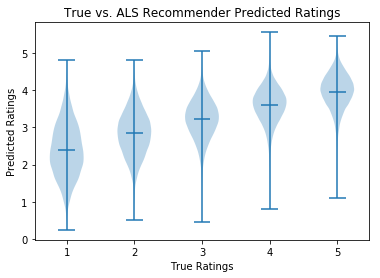

In [51]:
data = [pandas_preds['prediction'][pandas_preds['rating'] == rating] for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [ ]:
# fintest = recommender.transform(rdd)
# pandas_fin = fintest.toPandas()
# pandas_fin = pandas_fin.drop(columns='rating')
# pandas_fin = pandas_fin.fillna(mu)
# pandas_fin['rating'] = pandas_fin['prediction']
# pandas_fin = pandas_fin.drop(columns='prediction')

In [43]:
requests = pd.read_csv('data/requests.csv')
requests.head()

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


In [41]:
final = pd.merge(requests, final_pred, how='left', left_on=['user','movie'],right_on=['user','movie'] )

In [44]:
final.to_csv('data/ensemble1.csv')

In [45]:
final_pred.head()

,user,movie,rating
0,53,148,2.785714
1,4169,148,3.152981
2,5333,148,2.516377
3,4387,148,2.352893
4,840,148,2.542370
